# 04: Data Preparation for Initial Run

- Segment images into smaller sizes that will be fed into the model
- Create data cleaning methods as necessary (ie., census data may need to averaged over boundaries)

Just noting that this seems like a cool resource:
- https://pytorch.org/blog/geospatial-deep-learning-with-torchgeo/
- TorchGeo for deep learning with Pytorch - not exactly sure how to use right now

In [72]:
import numpy as np
import rioxarray
import xarray as xr
import earthpy.plot as ep

## First, review both tif files

In [121]:
landsat = rioxarray.open_rasterio('../data/test_japan_landsat.tif')
landsat_ds = landsat.to_dataset('band')
names = {i + 1 : landsat_ds.attrs['long_name'][i] for i in range(9)}
landsat_ds = landsat_ds.rename(names)

census = rioxarray.open_rasterio('../data/test_japan_census.tif')
census_ds = census.to_dataset('band')
census_ds = census_ds.rename({1: 'population_count'})

In [12]:
landsat_ds

<xarray.Dataset>
Dimensions:      (y: 3582, x: 14632)
Coordinates:
  * x            (x) float64 136.6 136.6 136.6 136.6 ... 140.5 140.5 140.5 140.5
  * y            (y) float64 36.61 36.61 36.61 36.61 ... 35.64 35.64 35.64 35.64
    spatial_ref  int64 0
Data variables:
    B1           (y, x) uint8 ...
    B2           (y, x) uint8 ...
    B3           (y, x) uint8 ...
    B4           (y, x) uint8 ...
    B5           (y, x) uint8 ...
    B6_VCID_1    (y, x) uint8 ...
    B6_VCID_2    (y, x) uint8 ...
    B7           (y, x) uint8 ...
    B8           (y, x) uint8 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1', 'B2', 'B3', 'B4', 'B5', 'B6_VCID_1', 'B6_VCID_2', '...

In [13]:
census_ds

<xarray.Dataset>
Dimensions:           (y: 109, x: 440)
Coordinates:
  * x                 (x) float64 136.6 136.6 136.6 136.6 ... 140.5 140.5 140.5
  * y                 (y) float64 36.61 36.6 36.59 36.58 ... 35.66 35.65 35.64
    spatial_ref       int64 0
Data variables:
    population_count  (y, x) float32 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     population_count

For now, I think I want to try to map each pixel of `census_ds` to a group of pixels in `landsat_ds`.

In [19]:
census_ds.x.values[:10]

array([136.59774716, 136.60673031, 136.61571346, 136.62469662,
       136.63367977, 136.64266292, 136.65164608, 136.66062923,
       136.66961238, 136.67859553])

In [65]:
census_ds.y.values[:10]

array([36.60863109, 36.59964794, 36.59066478, 36.58168163, 36.57269848,
       36.56371532, 36.55473217, 36.54574902, 36.53676587, 36.52778271])

In [32]:
landsat_in_census = [x for x in landsat_ds.x.values if (x < 136.606730 and x > 136.597747)]
len(landsat_in_census)

34

In [33]:
len(landsat_ds.x.values)/len(census_ds.x.values)

33.25454545454546

In [68]:
first_clip = landsat.rio.clip_box(minx = census_ds.x.values[0], maxx = census_ds.x.values[1],
                     miny = census_ds.y.values[1], maxy = census_ds.y.values[0])

In [69]:
first_clip_ds = first_clip.to_dataset('band')
first_clip_ds = first_clip_ds.rename(names)

In [70]:
first_clip_ds

<xarray.Dataset>
Dimensions:      (y: 28, x: 34)
Coordinates:
  * x            (x) float64 136.6 136.6 136.6 136.6 ... 136.6 136.6 136.6 136.6
  * y            (y) float64 36.61 36.61 36.61 36.61 ... 36.6 36.6 36.6 36.6
    spatial_ref  int64 0
Data variables:
    B1           (y, x) uint8 39 40 42 42 43 45 43 45 ... 33 33 34 34 29 31 34
    B2           (y, x) uint8 31 33 37 37 39 40 38 39 ... 28 28 26 26 24 26 27
    B3           (y, x) uint8 30 33 36 36 39 40 37 40 ... 28 28 25 25 22 22 25
    B4           (y, x) uint8 40 39 41 41 43 47 45 45 ... 32 33 33 33 38 31 27
    B5           (y, x) uint8 42 48 55 55 53 46 44 55 ... 27 27 29 29 25 26 24
    B6_VCID_1    (y, x) uint8 200 199 200 200 200 200 ... 181 181 181 181 181
    B6_VCID_2    (y, x) uint8 200 199 199 199 200 199 ... 181 181 182 182 182
    B7           (y, x) uint8 32 40 48 48 44 31 27 42 ... 15 14 14 14 15 17 17
    B8           (y, x) uint8 38 39 40 42 41 45 45 44 ... 31 32 32 30 29 30 28
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1', 'B2', 'B3', 'B4', 'B5', 'B6_VCID_1', 'B6_VCID_2', '...

In [71]:
rgb_bands = [first_clip_ds.B3, first_clip_ds.B2, first_clip_ds.B1]
landsat_rgb = xr.concat(rgb_bands, dim = "band")

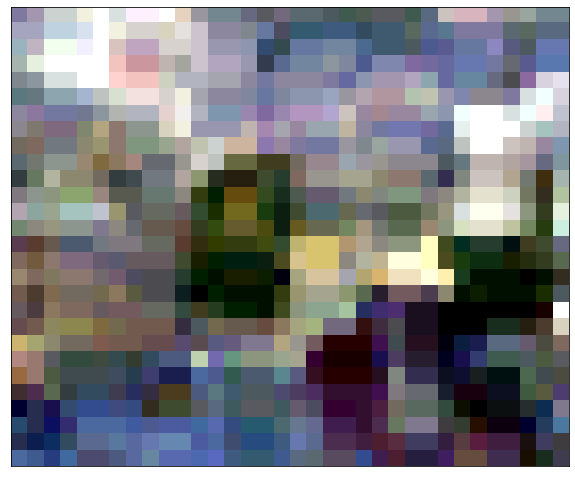

<AxesSubplot:>

In [78]:
ep.plot_rgb(landsat_rgb.values, stretch = True)

- We can use the `clip_box` function to generate an image for each census point.
- I'm kind of worried this is actually way to small of an image. I sure can't tell what is being shown here.
- The census data has ~ 1km grid cells, which is very small. What if I make it 5 km?

In [105]:
# try 5 km
second_clip = landsat.rio.clip_box(minx = census_ds.x.values[0], maxx = census_ds.x.values[4],
                     miny = census_ds.y.values[4], maxy = census_ds.y.values[0])

In [106]:
second_clip_ds = second_clip.to_dataset('band')
second_clip_ds = second_clip_ds.rename(names)

In [107]:
second_clip_ds

<xarray.Dataset>
Dimensions:      (y: 128, x: 134)
Coordinates:
  * x            (x) float64 136.6 136.6 136.6 136.6 ... 136.6 136.6 136.6 136.6
  * y            (y) float64 36.61 36.61 36.61 36.61 ... 36.57 36.57 36.57 36.57
    spatial_ref  int64 0
Data variables:
    B1           (y, x) uint8 39 40 42 42 43 45 43 45 ... 43 44 40 39 39 36 35
    B2           (y, x) uint8 31 33 37 37 39 40 38 39 ... 39 41 38 36 36 33 32
    B3           (y, x) uint8 30 33 36 36 39 40 37 40 ... 38 37 38 35 35 35 31
    B4           (y, x) uint8 40 39 41 41 43 47 45 45 ... 44 43 41 42 42 40 38
    B5           (y, x) uint8 42 48 55 55 53 46 44 55 ... 43 49 41 45 45 33 21
    B6_VCID_1    (y, x) uint8 200 199 200 200 200 200 ... 198 199 199 200 199
    B6_VCID_2    (y, x) uint8 200 199 199 199 200 199 ... 198 199 199 199 199
    B7           (y, x) uint8 32 40 48 48 44 31 27 42 ... 36 44 33 32 32 22 15
    B8           (y, x) uint8 38 39 40 42 41 45 45 44 ... 44 40 38 42 39 40 37
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1', 'B2', 'B3', 'B4', 'B5', 'B6_VCID_1', 'B6_VCID_2', '...

In [108]:
rgb_bands = [second_clip_ds.B3, second_clip_ds.B2, second_clip_ds.B1]
landsat_rgb = xr.concat(rgb_bands, dim = "band")

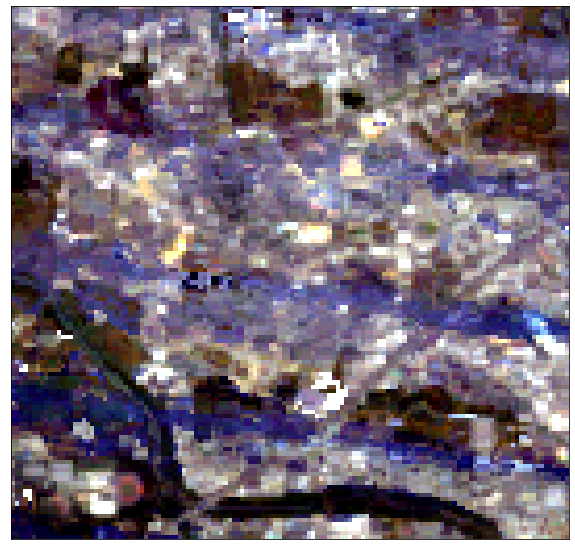

<AxesSubplot:>

In [109]:
ep.plot_rgb(landsat_rgb.values, stretch = True)

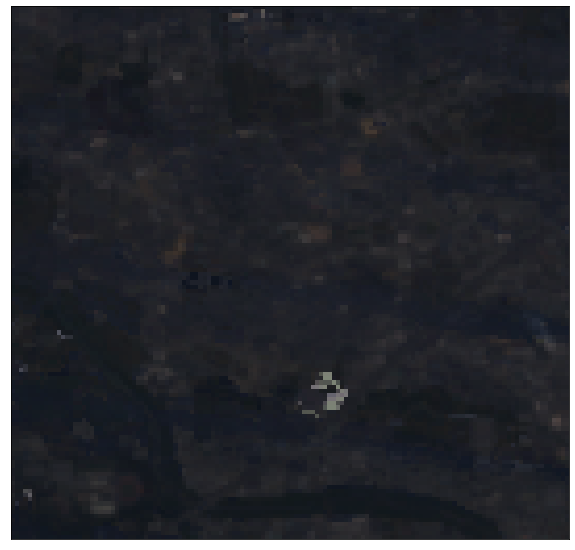

<AxesSubplot:>

In [110]:
ep.plot_rgb(landsat_rgb.values)

This looks like I can make out some of the buildings a bit better. So let's try with 5km.
It seems though that I will probably not be able to see buildings with the 30m resolution (makes sense). I'm wondering to what resolution I will be able to predict population.

After some thought, I think it may be very hard to see population from satellite imagery (houses don't immediately get broken down because no one lives there, there may be empty apartments, etc), but it's probably a good way to get a ballpark of population.

I should investigate if night lights from VIIRS night lights actually correspond to population decline. If not, I may have to rethink the direction of this project.

*Process*
- Create (n, 7, image_x_pixels, image_y_pixels) numpy array for landsat images
    - n is the number of images
    - Use first 7 bands
    - Since image_x_pixels and image_y_pixels may slightly differ, I may need to transform it in pytorch to all be the same size. --> I realized that I cannot create a numpy array when all the arrays are different sizes (image_x_pixels and image_y_pixels differ), so I will first slice the landsat and then map to the census.
- Create a (n, ) numpy array with the corresponding population
- Bin the population into categories and return a (n, ) numpy array with the proper categories

## Create (n, 7, image_x_pixels, image_y_pixels) numpy array for landsat images

In [131]:
def process_landsat(landsat : "xarray array", census_ds : "xarray dataset", scale : int):
    """
    landsat: xarray data array
        Landsat image read in with rioxarray
    census_ds: xarray dataset
        Census image
    scale: how many pixels of census image to aggregate
    """

    #For now, cut off image where there are not enough to meet the scale
    num_x = len(census_ds.x) // scale
    num_y = len(census_ds.y) // scale

    images = []

    for i in range(2):
        for j in range(2):

            print("Start: ", scale * i)
            print("End: ", scale * i + scale - 1)

            clipped_landsat = landsat.rio.clip_box(minx = census_ds.x.values[scale * i],
                                                   maxx = census_ds.x.values[scale * i + scale - 1],
                                                   miny = census_ds.y.values[scale * j + scale - 1],
                                                   maxy = census_ds.y.values[scale * j])
            print(clipped_landsat.values.shape)
            images.append(clipped_landsat.values)

    images_np = np.vstack(images)

    return images_np

In [132]:
processed_images = process_landsat(landsat, census_ds, 5)

Start:  0
End:  4
(9, 128, 134)
Start:  0
End:  4
(9, 135, 134)
Start:  5
End:  9
(9, 128, 134)
Start:  5
End:  9
(9, 135, 134)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 128 and the array at index 1 has size 135